# Machine Learning Models
The following classification models are carried out here:
    1. Random Forest
    2. Support Vector Machines
    3. Feed-forward Neural Networks

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.multioutput
import sklearn.neural_network
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans


%matplotlib inline

# 1. Load in data

In [2]:
X_16 = pd.read_csv('../../../Data/model_inputs/gdf_2016_X.csv')
y_16 = pd.read_csv('../../../Data/model_inputs/gdf_2016_y.csv')
X_17 = pd.read_csv('../../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../../Data/model_inputs/gdf_2017_y.csv')

In [4]:
def boolean_to_num(row):
    if row:
        return 1
    else:
        return 0
if not type(X_16['downtown_s'][0]) == np.int64:
    print('changing booleans to numbers')
    for col in ['downtown_s','downtown_e','morning','midday','afternoon','evening','midnight']:
        X_16[col] = X_16[col].apply(boolean_to_num)
        X_17[col] = X_17[col].apply(boolean_to_num)

changing booleans to numbers


##### Dependent variable class sizes
Purpose: {'leisure': 0, 'food_drink': 1, 'shops': 2, 'pick_up_drop_off': 3, 'education': 4, 'health': 5}
Mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [5]:
print('Dependent variable class sizes 2016:')
y_16['purpose'].value_counts()

Dependent variable class sizes 2016:


0    7430
1    5790
2    5682
3    2473
4    2262
5    2168
Name: purpose, dtype: int64

In [6]:
print('Dependent variable class sizes 2017:')
y_17['purpose'].value_counts()

Dependent variable class sizes 2017:


0    8049
2    7723
1    2714
4    2175
3    1379
5     908
Name: purpose, dtype: int64

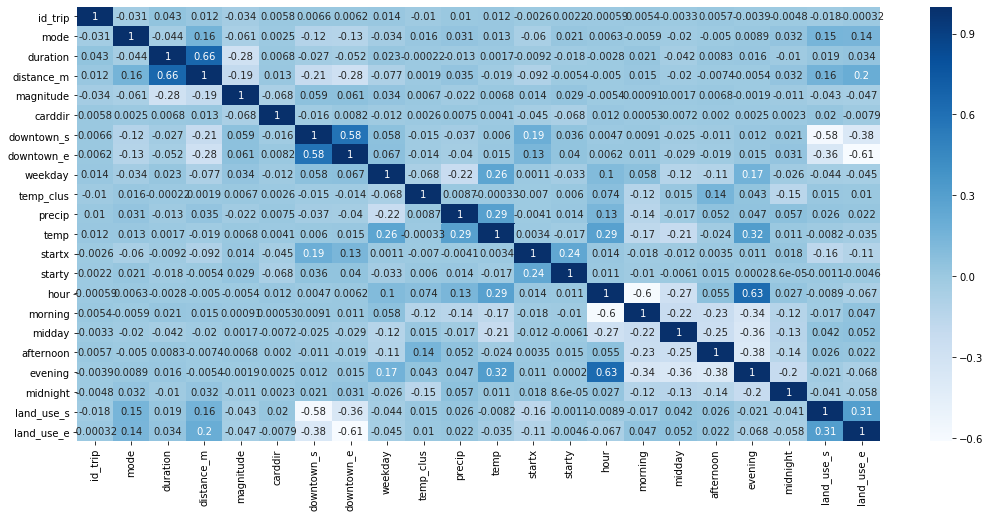

In [7]:
ax, fig = plt.subplots(1, figsize=(18,8))
sns.heatmap(X_16.corr(), cmap='Blues', annot=True)

# 2. Setup model
#### Section Overview:
2.1  Split data into training and testing  
2.2  Remove trip ID's from train/test data  
2.3  Calculate p_nearby

In [8]:
combined_X = pd.concat([X_16, X_17],axis=0)
combined_y = pd.concat([y_16, y_17],axis=0)
combined_X.reset_index(drop=True, inplace=True)
combined_y.reset_index(drop=True, inplace=True)

In [9]:
# check for no duplicates
combined_X.id_trip.value_counts()

67583      1
3196210    1
2379075    1
23873      1
2598206    1
          ..
3488209    1
2013826    1
3580545    1
2271872    1
466134     1
Name: id_trip, Length: 48753, dtype: int64

In [10]:
# check for no duplicates
combined_y.purpose.value_counts()

0    15479
2    13405
1     8504
4     4437
3     3852
5     3076
Name: purpose, dtype: int64

In [11]:
# define main data
all_X = combined_X.copy()
all_y = combined_y.copy()

### 2.1 Split data into training and testing

In [12]:
def normalise(X, to_normalize):
    """
        Feature scaling method.
        Normalises an array between 0–1 using the Z-score
        (i - min) / (max - min)
    """
    for col in X.columns[to_normalize]:
        row_min = X[col].min()
        row_max = X[col].max()
        X[col] = X[col].apply(lambda row: (row - row_min)/(row_max - row_min))
    return X
    

def model_setup(X, y, test_size=0.33, norm=False, to_normalise=[]):
    """
        All operations needed for preparing the model inputs.
        Can apply normalisation and then will apply the train/test split
    """
    if norm:
        X = normalise(X, to_normalise)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size,\
                                                                                random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test    

##### IMPORTANT
Train Test Split for encoded and non-encoded

In [17]:
non_categorical_features = [False,False,True,True,True,False,False,False,False,False,True,\
                        True,False,False,False,False,False,False,False,False,False,False]

In [18]:
all_X.columns[non_categorical_features]

Index(['duration', 'distance_m', 'magnitude', 'precip', 'temp'], dtype='object')

In [20]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(all_X, all_y, norm=True, test_size=0.33, to_normalise=non_categorical_features)



In [21]:
X_train.head()

,id_trip,mode,duration,distance_m,magnitude,carddir,downtown_s,downtown_e,weekday,temp_clus,...,startx,starty,hour,morning,midday,afternoon,evening,midnight,land_use_s,land_use_e
13051,3592784,2,0.015505,0.015059,0.935970,3,1,1,1,4,...,7.629479e+06,1.254025e+06,16,0,0,1,0,0,1,1
37551,152350,2,0.048111,0.034086,0.169275,0,0,0,1,2,...,7.619616e+06,1.265810e+06,23,0,0,0,0,1,1,1
7582,1959960,2,0.156737,0.138435,0.677456,11,1,0,0,1,...,7.627604e+06,1.244069e+06,19,0,0,0,1,0,1,5
48160,204665,2,0.126010,0.027076,0.555760,13,1,1,1,4,...,7.626442e+06,1.249992e+06,21,0,0,0,1,0,4,0
30591,123314,3,0.077711,0.031316,0.315754,15,1,1,1,1,...,7.629966e+06,1.246249e+06,13,0,1,0,0,0,0,6


### 2.2  Remove trip ID's

In [22]:
training_ids = X_train['id_trip'].copy()
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip'].copy()
X_test = X_test.drop('id_trip', axis=1)

In [23]:
## flatten data i.e. from Pd.Series to np.array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [24]:
feature_list = list(X_train.columns)
print('all_features:\n\n', feature_list)

all_features:

 ['mode', 'duration', 'distance_m', 'magnitude', 'carddir', 'downtown_s', 'downtown_e', 'weekday', 'temp_clus', 'precip', 'temp', 'startx', 'starty', 'hour', 'morning', 'midday', 'afternoon', 'evening', 'midnight', 'land_use_s', 'land_use_e']


## 2.3 Calculate p_nearby
Proportion of other trips that ended nearby with a given purpose

## 2.4 Calculate spatial clusters

In [26]:
# Calculate DISTANCE MATRIX
coords_st = [[x,y] for x, y in zip(all_X['startx'], all_X['starty'])]
coords_en = [[x,y] for x, y in zip(all_X['endx'], all_X['endy'])]

# get a list of all end-points for clustering algorithm
overall_coords = coords_st
overall_coords.extend(coords_en)

KeyError: 'endx'

In [ ]:
%%time
kmeans = KMeans(n_clusters=12, random_state=0).fit(overall_coords)
kmeans.labels_

In [ ]:
gdf_2016['startclust'] = kmeans.labels_[:int(len(gdf_2016))]
gdf_2016['endclust'] = kmeans.labels_[int(len(gdf_2016)):]

In [ ]:
print(gdf_2016.startclust.value_counts())
print(gdf_2016.endclust.value_counts())

In [ ]:
col_order = ['0','1','2','3','4','5','6','7','8','9','10','11']

sns.set_style("darkgrid")
grouped_cluster_origin = gdf_2016.groupby('startclust').count()['mode']
grouped_cluster_destination = gdf_2016.groupby('endclust').count()['mode']

fig, ax = plt.subplots(1, figsize=(10,6))
ind = np.arange(len(grouped_cluster_origin))
height = .3

ax.barh(y=ind, width=grouped_cluster_origin, height=height, alpha=.75)
ax.barh(y=ind+height, width=grouped_cluster_destination,height=height, color='orange', alpha=.75)
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(col_order, size=16)
ax.set_ylabel("Cluster ID", size=20)
plt.xticks(size=14)
ax.set_xlabel("Count of Trips",size=20)
ax.set_title("Trips per clusters", size=24)
ax.legend(['origin', 'destination'], fontsize=16);
# ax.figure.savefig("figures/trips_per_cluster.png", bbox_inches='tight')

# 3. Begin Modelling
#### Section Overview:
3.1 Define model functions and test modelling   
3.2 Preliminary modelling for important feature extraction  
3.3 Re-run models  

#### Model functions:
- `run_rf` == run the random forest classification model.
- `run_sv` == run the support vector machine classification model.
- `run_ann` == run the multi-layer perceptron classification model.  
- `run_mcrf` == *Experimental* run the multi-output random forest classification model.

#### Notes:

#### Technical Notes:
- each model will have a cross-validation option. To use this the function parameters will need to be set to `cv=True` and `cv_val` to the number of k-folds defaulting to `cv_val=5`

### 3.1 Define model functions and test

In [35]:
# All Model functions
def run_rf(X_train, X_test, y_train, y_test, n_estimators=10, cv=False, cv_val=5):
    """
        Run a random forest classification model with option to use cross-validation
    """
    cv_scores = []
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    if cv:
        cv_scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    print("Random Forest Classifcation accuracy:", score)
    return clf, score, preds, cv_scores


def run_svc(X_train, X_test, y_train, y_test, gamma_val=0.01, C_val=0.1, cv=False, cv_val=5):
    """
        Run a support vector classification model with option to use cross-validation
    """
    cv_scores = []
    if cv:
        clf = sklearn.svm.SVC(gamma=gamma_val, C=C_val, decision_function_shape='ova')
        cv_scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf = sklearn.svm.SVC(gamma=gamma_val, C=C_val, decision_function_shape='ova')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)  
    print("Support Vector classification accuracy:", score)
    return score, preds, cv_scores


def run_ann(X_train, X_test, y_train, y_test, alpha_val=0.01, C_val=0.1, cv=False, cv_val=5):
    """
        Run a neural network classification model with option to use cross-validation
    """
    cv_scores = []
    if cv:
        clf = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=alpha_val,\
                                            hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
        cv_scores = sklearn.model_selection.cross_val_score(clf,X_train,y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=alpha_val,\
                                               hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)
    print("Neural Network classification accuracy:", score)
    return score, preds, cv_scores


## Experimental
def run_mcrf(X_train, X_test, y_train, y_test, n_estimators=10, cv=False, cv_val=5):
    """
        Not currently in use.
        Run a multi-ouput random forest classification model with option to use cross-validation
    """
    cv_scores = []
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators = n_estimators,\
                                                  criterion = 'entropy', random_state = 42)
    multi_target_forest = sklearn.multioutput.MultiOutputClassifier(clf, n_jobs=-1)
    if cv:
        cv_scores = sklearn.model_selection.cross_val_score(multi_target_forest, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    multi_target_forest.fit(X_train, y_train)
    score = multi_target_forest.score(X_test, y_test)
    preds = multi_target_forest.predict(X_test)
    print("Multi-output Random Forest classification accuracy:", score)
    return score, preds, cv_scores

#### 3.1.1 test models

In [43]:
%%time
_, _, _, _ = run_rf(X_train, X_test, y_train, y_test,cv=False)

Random Forest Classifcation accuracy: 0.47099899507846116
CPU times: user 3.07 s, sys: 142 ms, total: 3.21 s
Wall time: 1.19 s


In [44]:
%%time
_, _, _, _ = run_rf(X_train, X_test, y_train, y_test,cv=True)

cv scores: [0.46517381 0.47335025 0.46706435 0.4707413  0.47201066]
Random Forest Classifcation accuracy: 0.4714370378005102
CPU times: user 4.54 s, sys: 1.56 s, total: 6.1 s
Wall time: 10.5 s


In [ ]:
%%time
_, _, _ = run_svc(X_train, X_test, y_train, y_test,cv=False)

In [ ]:
%%time
_, _, _ = run_svc(X_train, X_test, y_train, y_test,cv=True)

In [ ]:
%%time
_, _, _ = run_ann(X_train, X_test, y_train, y_test,cv=False)

In [ ]:
%%time
_, _, _ = run_ann(X_train, X_test, y_train, y_test,cv=True)

### 3.2 Run RF to subset data features by the feature importance metric

In [18]:
def calc_feature_imp(clf, feature_list, threshold):
    """
        function for extracting feature importance from rf model then prepare the
        data for subsetting based on a threshold of the relative feature importance metric
    """
    # Get numerical feature importances
    importances = list(clf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
    print(feature_importances)
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    above_threshold = [i[0] if i[1] >= threshold else "" for i in feature_importances]
    return feature_importances, above_threshold


def subset_to_imp_features(data, above_threshold):
    """
        function for subsetting the training/test data to only input features with feature
        importance above the threshold
    """
    above_threshold.append("id_trip")
    data = data[data.columns[[col in above_threshold for col in data.columns]]]
    return data


def plot_feature_imp(feature_importances, title):    
    """
        function for plotting the feature importance from the RF model of all the input features
    """
    fig, ax = plt.subplots(1, figsize=(10,6))
    feat_imp = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
    feat_imp = feat_imp.loc[(feat_imp.importance != 'id_trip')]
    feat_imp.plot(kind='barh', ax=ax, legend=False)
    ax.set_yticklabels([new_column_labels[i] for i in list(feat_imp.importance.values)], size=16);
    plt.xticks(size=16);
    ax.set_xlim(0,0.2)
    ax.axvline(0.05, -10,40, color='r',linestyle='--')
    ax.set_xlabel("Feature Importance", size=20)
    ax.set_ylabel("Feature", size=20)
    ax.set_title("{0}".format(title), size=22)
    return ax

In [36]:
def feature_selection(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    print("model score before feature extraction: ", model.score(X_test, y_test))
    perm = PermutationImportance(model).fit(X_test, y_test)
    
    
    # perm.feature_importances_ attribute is now available, it can be used
    # for feature selection - let's e.g. select features which increase
    # accuracy by at least 0.01:
    sel = SelectFromModel(perm, threshold=0.01, prefit=True)
    X_subset_train = sel.transform(X_train)
    X_subset_test = sel.transform(X_test)
    return model, X_subset_train, X_subset_test, perm
    

In [37]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
clf, X_subset_train, X_subset_test, perm = feature_selection(clf, X_train, X_test, y_train, y_test)
eli5.show_weights(perm)

model score before feature extraction:  0.470045607977531


Weight,Feature
0.0568 ± 0.0026,x17
0.0523 ± 0.0036,x8
0.0439 ± 0.0030,x10
0.0297 ± 0.0029,x7
0.0292 ± 0.0033,x9
0.0201 ± 0.0021,x2
0.0127 ± 0.0017,x1
0.0115 ± 0.0013,x0
0.0096 ± 0.0023,x11
0.0095 ± 0.0020,x15


In [44]:
clf = sklearn.svm.SVC(gamma=0.01, C=5, decision_function_shape='ova')
clf, X_subset_train, X_subset_test, perm = feature_selection(clf, X_train, X_test, y_train, y_test)
eli5.show_weights(perm)

model score before feature extraction:  0.4457986549511711


Weight,Feature
0.1131 ± 0.0029,x17
0.0386 ± 0.0009,x7
0.0129 ± 0.0016,x6
0.0070 ± 0.0018,x15
0.0025 ± 0.0010,x16
0.0025 ± 0.0012,x12
0.0022 ± 0.0013,x14
0.0017 ± 0.0011,x0
0.0013 ± 0.0011,x10
0.0012 ± 0.0006,x8


In [45]:
clf = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=0.01,\
                                               hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
clf, X_subset_train, X_subset_test, perm = feature_selection(clf, X_train, X_test, y_train, y_test)
eli5.show_weights(perm)

model score before feature extraction:  0.46002215980829186


Weight,Feature
0.0986 ± 0.0033,x17
0.0337 ± 0.0019,x7
0.0228 ± 0.0024,x15
0.0195 ± 0.0006,x10
0.0162 ± 0.0008,x0
0.0149 ± 0.0015,x6
0.0142 ± 0.0019,x12
0.0113 ± 0.0011,x16
0.0106 ± 0.0015,x14
0.0102 ± 0.0012,x13


In [46]:
# clf.fit(X_trans_train, y_train)
# clf.score(X_trans_test, y_test)

In [41]:
X_test.columns[[17,8,10,7,9,2,1,0]]

Index(['land_use_e_f', 'temporal_c', 'temperatur', 'weekday', 'precip',
       'distance_m', 'duration', 'mode_f'],
      dtype='object')

In [38]:
X_subset_train.shape

(78794, 8)

In [91]:
## ORIGINAL WAY OF EXTRACTING
# # Train Test Split
# X_train, X_test, y_train, y_test  = model_setup(all_X, all_y, norm=True, test_size=0.33, to_normalize=non_categorical_features)
# feature_list = list(X_train.columns)
# training_ids = X_train['id_trip']
# X_train = X_train.drop('id_trip', axis=1)
# testing_ids = X_test['id_trip']
# X_test = X_test.drop('id_trip', axis=1)

# # run a model
# clf, _, _, _ = run_rf(X_train, X_test, y_train, y_test,cv=False)
# # extract feature importances
# feature_importances, above_thresh = calc_feature_imp(clf, feature_list, threshold=0.01)
# above_thresh[:]
# feature_importances
# subset_X = subset_to_imp_features(all_X,above_thresh)

### 3.3 Re-build the models with new subset data

#### Note:

purpose = {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4, 'pick_up_drop_off': 5, 'education': 6, 'health': 7}  

In [33]:
# Train Test Split
X_train, X_test, y_train, y_test = model_setup(subset_X, all_y, norm=True, test_size=0.33, to_normalise=non_categorical_features)

In [34]:
training_ids = X_train['id_trip']
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip']
X_test = X_test.drop('id_trip', axis=1)

In [35]:
rf_clf, rf_score, rf_preds, rf_cv_scores = run_rf(X_train, X_test, y_train, y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Random Forest Classifcation accuracy: 0.4326316060707568


In [36]:
print('predictions for each class by RF:', collections.Counter(rf_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(y_test, rf_preds))

predictions for each class by RF: Counter({0: 18524, 4: 10751, 1: 4137, 3: 3001, 2: 1588, 6: 355, 5: 254, 7: 199}) 

              precision    recall  f1-score   support

           0       0.46      0.67      0.54     12546
           1       0.24      0.20      0.22      5108
           2       0.20      0.12      0.15      2806
           3       0.27      0.18      0.22      4424
           4       0.57      0.60      0.58     10175
           5       0.13      0.03      0.04      1271
           6       0.15      0.04      0.06      1464
           7       0.13      0.03      0.04      1015

    accuracy                           0.43     38809
   macro avg       0.27      0.23      0.23     38809
weighted avg       0.39      0.43      0.40     38809



In [37]:
svc_score, svc_preds, svc_cv_score = run_svc(X_train, X_test, y_train, y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector classification accuracy: 0.3523667190600119


In [38]:
print('predictions for each class by SVC:', collections.Counter(svc_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(y_test, svc_preds))

predictions for each class by SVC: Counter({0: 25204, 4: 13605}) 

              precision    recall  f1-score   support

           0       0.35      0.70      0.47     12546
           1       0.00      0.00      0.00      5108
           2       0.00      0.00      0.00      2806
           3       0.00      0.00      0.00      4424
           4       0.36      0.48      0.41     10175
           5       0.00      0.00      0.00      1271
           6       0.00      0.00      0.00      1464
           7       0.00      0.00      0.00      1015

    accuracy                           0.35     38809
   macro avg       0.09      0.15      0.11     38809
weighted avg       0.21      0.35      0.26     38809



/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
nn_score, nn_preds, nn_cv_score = run_ann(X_train, X_test, y_train, y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Neural Network classification accuracy: 0.4605890386250612


In [40]:
print('predictions for each class by ANN:', collections.Counter(nn_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(y_test, nn_preds))

predictions for each class by ANN: Counter({0: 20052, 4: 12759, 3: 2779, 1: 2376, 2: 831, 7: 5, 6: 4, 5: 3}) 

              precision    recall  f1-score   support

           0       0.46      0.74      0.57     12546
           1       0.32      0.15      0.20      5108
           2       0.26      0.08      0.12      2806
           3       0.31      0.19      0.24      4424
           4       0.53      0.67      0.59     10175
           5       0.33      0.00      0.00      1271
           6       0.50      0.00      0.00      1464
           7       0.20      0.00      0.00      1015

    accuracy                           0.46     38809
   macro avg       0.36      0.23      0.22     38809
weighted avg       0.42      0.46      0.40     38809



# 4 Improve models
### Overview:
4.1 Encode model inputs (for ANN/SVC)   
4.2 Re-run models with encoded inputs  
4.3 Oversample  
4.4 add POI categories to model  

### 4.1 Encode model inputs
The model inputs are encoded to improve the performance of ANN/SVC models. Specifically by One-hot encoding all the 

#### Encoded inputs:
- Trip mode *(f)*
- Cardinal Direction *(f)*
- Trip starting & ending cluster from K-means (see `./Notebooks/preprocessing/metric_creation/clustering.ipynb`)
- Temporal cluster from LDA
- Land-use at trip starting and ending points *(f)* (see `./Notebooks/preprocessing/metric_creation/land_use_poi.ipynb`)

*(f) == factors*

#### Note:
- for factor numbers see Data/model_inputs folder e.g. `./Data/model_inputs/gdf_2016_land_use_factors.txt`

In [72]:
# for One Hot Encoded data
enc_X = subset_X.copy()
enc_y = all_y.copy()

In [73]:
def encode_model_inputs(data, col):
    """
        function for applying a OneHotEncoder to a input feature 
    """
    encoded_input = ''
    if col in data.columns:
        encoded_input = enc.fit_transform(data[col].values.reshape(-1, 1)).toarray()
    return encoded_input


In [74]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')


In [75]:
encoded_inputs = {}
for col in ["mode","carddir","startclust","endclust", "temp_clus", "land_use_s", "land_use_e"]:
    if col in enc_X.columns:
        # 1. encode inputs
        encoded_inputs[col] = encode_model_inputs(enc_X, col)
        # 2. make a temporary df with encoded inputs and column names of format *col*_*factor*
        col_df = pd.DataFrame(encoded_inputs[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs[col].shape[1])])
        # 3. drop column from main data so that they can be concatenated
        enc_X = enc_X.drop(col, axis=1)
        # 4. concatenate the two data sets
        enc_X = pd.concat([enc_X, col_df], axis=1)

encoded_inputs['purpose'] = encode_model_inputs(enc_y, 'purpose')

# for multi-output predictions
multi_output_y = pd.DataFrame(encode_model_inputs(enc_y, 'purpose'), columns=['%s_%s' % ('purpose', i) for i in range(encoded_inputs['purpose'].shape[1])])


In [78]:
# view new data with columns following the *col*_*factor* syntax
enc_X.columns

Index(['id_trip', 'duration', 'distance_m', 'magnitude', 'end_downto',
       'weekday', 'precip', 'thrurush', 'mode_f_0', 'mode_f_1', 'mode_f_2',
       'mode_f_3', 'mode_f_4', 'mode_f_5', 'startclust_0', 'startclust_1',
       'startclust_2', 'startclust_3', 'startclust_4', 'startclust_5',
       'startclust_6', 'startclust_7', 'startclust_8', 'startclust_9',
       'startclust_10', 'startclust_11', 'endclust_0', 'endclust_1',
       'endclust_2', 'endclust_3', 'endclust_4', 'endclust_5', 'endclust_6',
       'endclust_7', 'endclust_8', 'endclust_9', 'endclust_10', 'endclust_11',
       'temporal_c_0', 'temporal_c_1', 'temporal_c_2', 'temporal_c_3',
       'temporal_c_4', 'land_use_s_f_0', 'land_use_s_f_1', 'land_use_s_f_2',
       'land_use_s_f_3', 'land_use_s_f_4', 'land_use_s_f_5', 'land_use_s_f_6',
       'land_use_s_f_7', 'land_use_s_f_8', 'land_use_s_f_9'],
      dtype='object')

In [79]:
# example of multi-output encoded inputs
multi_output_y.head()

,purpose_f_0,purpose_f_1,purpose_f_2,purpose_f_3,purpose_f_4,purpose_f_5,purpose_f_6,purpose_f_7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
%%time
# multi-output
multi_X_train, multi_X_test, multi_y_train, multi_y_test  = model_setup(all_X, multi_output_y, norm=True, test_size=0.33,to_normalise=non_categorical_features)
_, _, _ = run_mcrf(multi_X_train, multi_X_test, multi_y_train, multi_y_test,cv=False)

Multi-output Random Forest classification accuracy: 0.2694478084980288
CPU times: user 1.8 s, sys: 736 ms, total: 2.54 s
Wall time: 12.6 s


## 4.2 Re-run ANN/SVC with encoded inputs

In [81]:
# Train Test Split
enc_X_train, enc_X_test, enc_y_train, enc_y_test  = model_setup(enc_X, enc_y, norm=True, test_size=0.33,to_normalise=non_categorical_features)

In [82]:
enc_training_ids = enc_X_train['id_trip']
enc_X_train = enc_X_train.drop('id_trip', axis=1)
enc_testing_ids = enc_X_test['id_trip']
enc_X_test = enc_X_test.drop('id_trip', axis=1)

In [83]:
## flatten data i.e. from Pd.Series to np.array
enc_y_train = np.ravel(enc_y_train)
enc_y_test = np.ravel(enc_y_test)

In [84]:
enc_feature_list = list(enc_X_train.columns)
print('all_features:\n\n', enc_feature_list)

all_features:

 ['duration', 'distance_m', 'magnitude', 'end_downto', 'weekday', 'precip', 'thrurush', 'mode_f_0', 'mode_f_1', 'mode_f_2', 'mode_f_3', 'mode_f_4', 'mode_f_5', 'startclust_0', 'startclust_1', 'startclust_2', 'startclust_3', 'startclust_4', 'startclust_5', 'startclust_6', 'startclust_7', 'startclust_8', 'startclust_9', 'startclust_10', 'startclust_11', 'endclust_0', 'endclust_1', 'endclust_2', 'endclust_3', 'endclust_4', 'endclust_5', 'endclust_6', 'endclust_7', 'endclust_8', 'endclust_9', 'endclust_10', 'endclust_11', 'temporal_c_0', 'temporal_c_1', 'temporal_c_2', 'temporal_c_3', 'temporal_c_4', 'land_use_s_f_0', 'land_use_s_f_1', 'land_use_s_f_2', 'land_use_s_f_3', 'land_use_s_f_4', 'land_use_s_f_5', 'land_use_s_f_6', 'land_use_s_f_7', 'land_use_s_f_8', 'land_use_s_f_9']


In [85]:
enc_svc_score, enc_svc_preds, enc_svc_cv_score = run_svc(enc_X_train, enc_X_test, enc_y_train, enc_y_test)

Support Vector classification accuracy: 0.4342549408642325


In [86]:
print('predictions for each class by SVC with encoded inputs:', collections.Counter(enc_svc_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(enc_y_test, enc_svc_preds))

predictions for each class by SVC with encoded inputs: Counter({0: 27320, 4: 11489}) 

              precision    recall  f1-score   support

           0       0.40      0.86      0.54     12546
           1       0.00      0.00      0.00      5108
           2       0.00      0.00      0.00      2806
           3       0.00      0.00      0.00      4424
           4       0.53      0.59      0.56     10175
           5       0.00      0.00      0.00      1271
           6       0.00      0.00      0.00      1464
           7       0.00      0.00      0.00      1015

    accuracy                           0.43     38809
   macro avg       0.12      0.18      0.14     38809
weighted avg       0.27      0.43      0.32     38809



/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [87]:
enc_nn_score, enc_nn_preds, enc_nn_cv_score = run_ann(enc_X_train, enc_X_test, enc_y_train, enc_y_test)

Neural Network classification accuracy: 0.4627534850163622


In [88]:
print('predictions for each class by ANN with encoded inputs:', collections.Counter(enc_nn_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(enc_y_test, enc_nn_preds))

predictions for each class by ANN with encoded inputs: Counter({0: 18739, 4: 12520, 1: 3282, 3: 2834, 2: 1073, 6: 166, 7: 132, 5: 63}) 

              precision    recall  f1-score   support

           0       0.47      0.71      0.57     12546
           1       0.30      0.20      0.24      5108
           2       0.25      0.10      0.14      2806
           3       0.31      0.20      0.24      4424
           4       0.54      0.67      0.60     10175
           5       0.19      0.01      0.02      1271
           6       0.28      0.03      0.06      1464
           7       0.24      0.03      0.06      1015

    accuracy                           0.46     38809
   macro avg       0.32      0.24      0.24     38809
weighted avg       0.41      0.46      0.41     38809



In [89]:
print('SVC before', collections.Counter(svc_preds),'\n')
print(sklearn.metrics.classification_report(y_test, svc_preds))
print('SVC after', collections.Counter(enc_svc_preds),'\n')
print(sklearn.metrics.classification_report(enc_y_test, enc_svc_preds))


print('NN before', collections.Counter(nn_preds),'\n')
print(sklearn.metrics.classification_report(y_test, nn_preds))
print('NN after', collections.Counter(enc_nn_preds),'\n')
print(sklearn.metrics.classification_report(enc_y_test, enc_nn_preds))

SVC before Counter({0: 25204, 4: 13605}) 

              precision    recall  f1-score   support

           0       0.35      0.70      0.47     12546
           1       0.00      0.00      0.00      5108
           2       0.00      0.00      0.00      2806
           3       0.00      0.00      0.00      4424
           4       0.36      0.48      0.41     10175
           5       0.00      0.00      0.00      1271
           6       0.00      0.00      0.00      1464
           7       0.00      0.00      0.00      1015

    accuracy                           0.35     38809
   macro avg       0.09      0.15      0.11     38809
weighted avg       0.21      0.35      0.26     38809

SVC after Counter({0: 27320, 4: 11489}) 

              precision    recall  f1-score   support

           0       0.40      0.86      0.54     12546
           1       0.00      0.00      0.00      5108
           2       0.00      0.00      0.00      2806
           3       0.00      0.00      0.00    

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 4.3 Oversample

In [13]:
oversampled_X_16 = pd.read_csv('../../../Data/model_inputs/oversampled_X_2016.csv')
oversampled_y_16 = pd.read_csv('../../../Data/model_inputs/oversampled_y_2016.csv')
oversampled_X_17 = pd.read_csv('../../../Data/model_inputs/oversampled_X_2017.csv')
oversampled_y_17 = pd.read_csv('../../../Data/model_inputs/oversampled_y_2017.csv')

In [14]:
## CURRENT WORK AROUND to standardise mode and purpose factors
# to stop user switching back
if oversampled_X_17['mode'].values[0] == 0:
    print('changing')
    oversampled_y_17['purpose'] = oversampled_y_17['purpose'].apply(lambda row: swap_codes(purpose_code_16, purpose_code_17, row))
    oversampled_X_17['mode'] = oversampled_X_17['mode'].apply(lambda row: swap_codes(mode_code_16, mode_code_17, row))

changing


In [15]:
oversampled_y_16.purpose.value_counts()

7    15554
6    15554
5    15554
4    15554
3    15554
2    15554
1    15554
0    15554
Name: purpose_f, dtype: int64

In [16]:
oversampled_y_17.purpose.value_counts()

7    22464
6    22464
5    22464
4    22464
3    22464
2    22464
1    22464
0    22464
Name: purpose_f, dtype: int64

In [63]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(oversampled_X_17, oversampled_y_17, norm=False, test_size=0.33, to_normalise=non_categorical_features)

In [64]:
## Prepare Data
training_ids = X_train['id_trip']
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip']
X_test = X_test.drop('id_trip', axis=1)

## Flatten data i.e. from Pd.Series to np.array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

## Keep feature list
feature_list = list(X_train.columns)
print('all_features:\n\n', feature_list)

all_features:

 ['mode_f', 'duration', 'distance_m', 'magnitude', 'carddir_f', 'start_down', 'end_downto', 'weekday', 'temporal_c', 'precip', 'temperatur', 'startrush', 'endrush', 'thrurush', 'startclust', 'endclust', 'land_use_s_f', 'land_use_e_f']


In [65]:
len(X_train)

120407

In [66]:
run_rf(X_train, X_test, y_train, y_test)

Random Forest Classifcation accuracy: 0.7353680128151083


(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                        oob_score=False, random_state=None, verbose=0,
                        warm_start=False),
 0.7353680128151083,
 array([7, 1, 3, ..., 0, 1, 3]),
 [])

In [67]:
run_svc(X_train, X_test, y_train, y_test)

Support Vector classification accuracy: 0.15315740662675997


(0.15315740662675997, array([0, 0, 0, ..., 0, 0, 0]), [])

In [68]:
run_ann(X_train, X_test, y_train, y_test)

Neural Network classification accuracy: 0.12983728184807353


(0.12983728184807353, array([0, 3, 1, ..., 4, 1, 7]), [])

In [ ]:
## take a sample
# oversampled_17 = pd.concat([oversampled_X_17, oversampled_y_17],axis=1)
# sampled_oversampled_17 = oversampled_17.sample(10000)
# sampled_oversampled_17['purpose_f'].value_counts()
# not_y_columns = sampled_oversampled_17.columns[:-1]

## 4.4 add POI categories

In [ ]:
poi_16 = pd.read_csv('../../../Data/model_inputs/poi_categories_2016.csv')
poi_17 = pd.read_csv('../../../Data/model_inputs/poi_categories_2017.csv')

In [ ]:
print('MTL 2016 number of trips with purpose that overlap with a POI within 200 m')
len(X_16.merge(poi_16, on='id_trip', how='inner'))

In [ ]:
print('MTL 2017 number of trips with purpose that overlap with a POI within 200 m')
len(X_17.merge(poi_17, on='id_trip', how='inner'))

In [ ]:
merged_X_16 = X_16.merge(poi_16, on='id_trip', how='left')
merged_X_17 = X_17.merge(poi_17, on='id_trip', how='left')

In [ ]:
merged_X_16 = merged_X_16.fillna(0).copy()
merged_X_17 = merged_X_17.fillna(0).copy()

In [ ]:
X_train, X_test, y_train, y_test = model_setup(merged_X_17, y_17, norm=False, test_size=0.33, to_normalise=non_categorical_features)

In [ ]:
rf_clf, rf_score, rf_preds, rf_cv_scores = run_rf(X_train.fillna(0), X_test.fillna(0), y_train, y_test, cv=True)

In [ ]:
score, preds, cv_scores = run_svc(X_train.fillna(0), X_test.fillna(0), y_train, y_test, cv=False)

In [ ]:
score, preds, cv_scores = run_ann(X_train.fillna(0), X_test.fillna(0), y_train, y_test, cv=True)

In [ ]:
for col in ["mode","carddir","startclust","endclust", "temp_clus", "land_use_s", "land_use_e"]:
    if col in merged_X_17.columns:
        # 1. encode inputs
        encoded_inputs[col] = encode_model_inputs(enc_X, col)
        # 2. make a temporary df with encoded inputs and column names of format *col*_*factor*
        col_df = pd.DataFrame(encoded_inputs[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs[col].shape[1])])
        # 3. drop column from main data so that they can be concatenated
        enc_X = enc_X.drop(col, axis=1)
        # 4. concatenate the two data sets
        enc_X = pd.concat([enc_X, col_df], axis=1)


## Grid Search

In [ ]:
sklearn.model_selection.GridSearchCV